In [1]:
# Import Statements
import sys
import copy
import time
import eeg_utils
import numpy as np
from eeg_utils import *
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.python.client import device_lib
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2, L1L2
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import lecun_uniform
from tensorflow.keras.layers import Bidirectional, Flatten, Input, Permute
from tensorflow.keras.layers import Reshape, ConvLSTM2D, Attention, Lambda
from tensorflow.keras.layers import Dense, Dropout, ELU, ReLU, MaxPooling2D, Concatenate
from tensorflow.keras.layers import LSTM, Maximum, BatchNormalization, Conv2D, Conv2DTranspose

In [2]:
# Detect GPU
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


In [3]:
# Load EEG Data
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

In [4]:
# Visualize EEG Data Shapes
print("Training/Valid data shape: {}".format(X_train_valid.shape))
print("Test data shape: {}".format(X_test.shape))
print("Training/Valid target shape: {}".format(y_train_valid.shape))
print("Test target shape: {}".format(y_test.shape))
print("Person train/valid shape: {}".format(person_train_valid.shape))
print("Person test shape: {}".format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [5]:
# [RUN IFF] Train on Subject One ONLY
patient_data = []
patient_truths = []

test_data = []
test_truths = []

# # Uncomment if we want to train on patient 1 only
# for patient in np.unique(person_train_valid):
#     idx = np.where(person_train_valid == patient)[0]
#     patient_data.append(X_train_valid[idx, :, :])
#     patient_truths.append(y_train_valid[idx])
#     pass

# Uncomment if we want to test on patient 1 only
for patient in np.unique(person_test):
    idx = np.where(person_test == patient)[0]
    test_data.append(X_test[idx, :, :])
    test_truths.append(y_test[idx])
    pass

# # Uncomment below 2 lines if we train on patient 1 only
# X_train_valid = patient_data[0]
# y_train_valid = patient_truths[0]

# Uncomment below 2 lines if we test on patient 1 only
X_test = test_data[0]
y_test = test_truths[0]

In [6]:
# Preprocess and Split Training Data
data_config = {"Duplicate": 2, "Mu": 0.0, "Sigma": 0.5, "Time_Point": 500}
X_train_valid, y_train_valid, X_test, y_test = vae_preprocess_data(X_train_valid,
                                                               y_train_valid,
                                                               X_test,
                                                               y_test, 
                                                               data_config)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid,
                                                      y_train_valid,
                                                      test_size=0.2,
                                                      random_state=0)

In [7]:
# Define model hyperparameters
lr = 1e-3
r2 = 0.006
dropout = 0.5
iterations = 30
latent_dim = 10
channel_dim = 22
kernel_dim = 450
time_point = data_config["Time_Point"]

In [8]:
# VAE Architecture
encoder_inputs = Input(shape=(22, time_point, 1))

# Define the VAE Encoder
x = Conv2D(2, (1, kernel_dim), activation="elu", kernel_regularizer=l2(r2))(encoder_inputs) # (None, 22, 51, 2)
x = Conv2D(1, (channel_dim, 1), activation="elu", kernel_regularizer=l2(r2))(x) # (None, 1, 51, 1)
x = Flatten()(x) # (None, 51)
x = Dense(4, activation="softmax")(x) # (None, 4)

# Sampling process
z_mu = Dense(latent_dim)(x)
z_var = Dense(latent_dim)(x)
z = sampling([z_mu, z_var])

# Define the VAE Decoder
x = Dense(1 * (time_point-kernel_dim+1) * 1, activation="softmax")(z) # (None, 51)
x = Reshape((1, time_point - kernel_dim + 1, 1))(x) # (None, 1, 51, 1)

# Recover original EEG data shapes
x = Conv2DTranspose(1, (channel_dim, int(kernel_dim / 2)), 
                    activation="elu", kernel_regularizer=l2(r2))(x) # (None, 22, 275, 1)
x = Conv2DTranspose(1, (1, int(kernel_dim / 2)+1), 
                    activation="elu", kernel_regularizer=l2(r2))(x) # (None, 22, 500, 1)

decoder_outputs = Conv2DTranspose(1, 1, activation="sigmoid")(x) # (None, 22, 500, 1)
vae_output = Concatenate(axis=2)([encoder_inputs, decoder_outputs]) # (None, 22, 1000, 1)

# Basic CRNN hooked to the VAE
x = Conv2D(4, kernel_size=(1, 951), activation="elu", 
           padding="valid", kernel_regularizer=l2(r2))(vae_output)
x = MaxPooling2D(pool_size=(1, 5), padding="valid")(x)
x = BatchNormalization()(x)
x = Dropout(dropout)(x)

x = Conv2D(8, kernel_size=(channel_dim-1, 1), activation="elu", 
           padding="valid", kernel_regularizer=l2(r2))(x)
x = MaxPooling2D(pool_size=(1, 5), padding="valid")(x)
x = BatchNormalization()(x)
x = Dropout(dropout)(x)

# Retain shape information
x = Permute((2, 3, 1))(x)
x1 = (x.shape)[1]
x2 = (x.shape)[2]
x3 = (x.shape)[3]

x = Flatten()(x)
x = Reshape((x1*x2*x3,))(x)
output = Dense(4, activation="softmax")(x)

# Compile and build the model
model = keras.models.Model(inputs=encoder_inputs, outputs=output)
model.compile(loss="categorical_crossentropy", 
              optimizer=Adam(learning_rate=lr), 
              metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 22, 500, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 22, 51, 2)    902         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 1, 51, 1)     45          ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 51)           0           ['conv2d_1[0][0]']           

                                                                                                  
 dense_4 (Dense)                (None, 4)            132         ['reshape_1[0][0]']              
                                                                                                  
Total params: 11,664
Trainable params: 11,640
Non-trainable params: 24
__________________________________________________________________________________________________


In [9]:
# Find Optimal Model
train = False

if (train == True):
    # N.B. ONLY SET TO TRUE IF WE WANT NEW MODEL, OTHERWISE IT WILL OVERWRITE PREVIOUS MODEL
    filename = "VAE_Train_All_Test_One" # "VAE_Train_All" OR "VAE_Train_One" OR "VAE_Train_All_Test_One"
    best_acc, epoch_num = find_optimal_model(model, X_train, y_train, 
                                             X_valid, y_valid, X_test, 
                                             y_test, filename, iterations, 
                                             prev_best=-1.0, batches=16)

EPOCH: 1
2/2 [==============================] - 0s 123ms/step - loss: 1.4218 - accuracy: 0.3600
INFO:tensorflow:Assets written to: VAE_Train_All_Test_One\assets
EPOCH: 2
2/2 [==============================] - 0s 154ms/step - loss: 1.3561 - accuracy: 0.4400
INFO:tensorflow:Assets written to: VAE_Train_All_Test_One\assets
EPOCH: 3
2/2 [==============================] - 0s 137ms/step - loss: 1.3596 - accuracy: 0.4000
EPOCH: 4
2/2 [==============================] - 0s 138ms/step - loss: 1.3524 - accuracy: 0.4400
EPOCH: 5
2/2 [==============================] - 1s 184ms/step - loss: 1.3142 - accuracy: 0.4000
EPOCH: 6
2/2 [==============================] - 0s 136ms/step - loss: 1.3022 - accuracy: 0.4200
EPOCH: 7
2/2 [==============================] - 0s 114ms/step - loss: 1.2884 - accuracy: 0.4200
EPOCH: 8
2/2 [==============================] - 0s 134ms/step - loss: 1.2972 - accuracy: 0.4800
INFO:tensorflow:Assets written to: VAE_Train_All_Test_One\assets
EPOCH: 9
2/2 [=======================

In [10]:
# Plot the loss function to show that there is some progression over time
results = model.fit(X_train, y_train, batch_size=16, epochs=iterations, 
                     validation_data=(X_valid, y_valid), verbose=True)
losses = results.history

Epoch 1/30
212/212 [==============================] - 77s 362ms/step - loss: 1.9055 - accuracy: 0.2730 - val_loss: 1.4359 - val_accuracy: 0.3487
Epoch 2/30
212/212 [==============================] - 77s 364ms/step - loss: 1.5518 - accuracy: 0.3177 - val_loss: 1.3689 - val_accuracy: 0.3842
Epoch 3/30
212/212 [==============================] - 91s 430ms/step - loss: 1.4337 - accuracy: 0.3505 - val_loss: 1.3485 - val_accuracy: 0.3865
Epoch 4/30
212/212 [==============================] - 97s 458ms/step - loss: 1.3744 - accuracy: 0.3821 - val_loss: 1.3341 - val_accuracy: 0.3818
Epoch 5/30
212/212 [==============================] - 90s 427ms/step - loss: 1.3378 - accuracy: 0.3945 - val_loss: 1.3318 - val_accuracy: 0.4090
Epoch 6/30
212/212 [==============================] - 87s 410ms/step - loss: 1.3271 - accuracy: 0.4093 - val_loss: 1.3292 - val_accuracy: 0.4090
Epoch 7/30
212/212 [==============================] - 92s 437ms/step - loss: 1.2979 - accuracy: 0.4291 - val_loss: 1.3096 - val_ac

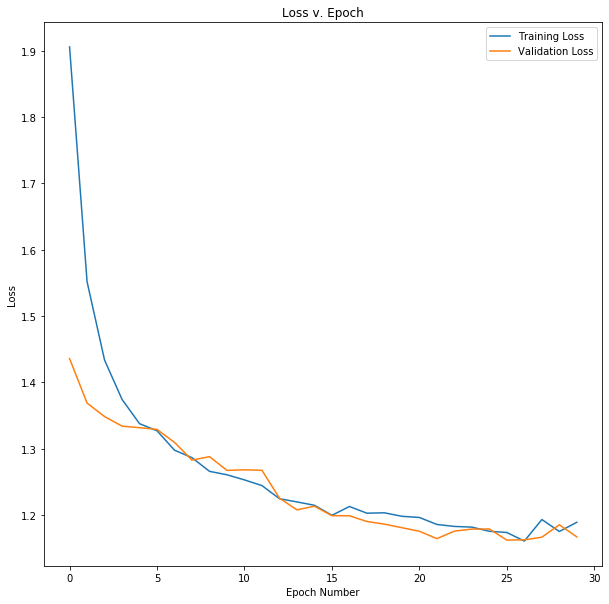

In [11]:
plt.figure(figsize=(10, 10))
plt.plot(losses["loss"])
plt.plot(losses["val_loss"])
plt.title("Loss v. Epoch")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.legend(["Training Loss", "Validation Loss"])